# Task 4: Optimize Portfolio Based on Forecast
## GMF Investments - Portfolio Optimization

**Objective:** Use insights from forecasts to construct an optimal portfolio using Modern Portfolio Theory (MPT).

**Key Activities:**
1. Prepare expected returns (TSLA from forecast, BND/SPY from history)
2. Compute covariance matrix from historical returns
3. Generate Efficient Frontier
4. Identify key portfolios (Max Sharpe, Min Volatility)
5. Recommend optimal portfolio with justification

**Assets:**
- **TSLA** - Forecasted expected return from Task 3
- **BND** - Historical average return
- **SPY** - Historical average return

---

### Modern Portfolio Theory (MPT):
MPT provides a mathematical framework for assembling portfolios that maximize expected return for a given level of risk, based on:
- Expected returns
- Risk (volatility/covariance)
- Correlation between assets

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Portfolio optimization (optional - will use fallback if not available)
try:
    from pypfopt import EfficientFrontier, risk_models, expected_returns
    from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
    from pypfopt.plotting import plot_efficient_frontier_and_max_sharpe, plot_covariance
    PYPFOPT_AVAILABLE = True
except ImportError:
    PYPFOPT_AVAILABLE = False
    print("Note: PyPortfolioOpt not available. Will use scipy.optimize fallback.")

# Optimization
from scipy.optimize import minimize
from scipy import stats

# Set random seeds
np.random.seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully!")
print("Portfolio optimization tools ready!")

Note: PyPortfolioOpt not available. Will use scipy.optimize fallback.
Libraries imported successfully!
Portfolio optimization tools ready!


## 1. Load Historical Data and Forecasts

In [2]:
# Load historical data for all assets
print("Loading historical data for TSLA, BND, and SPY...")

assets = ['TSLA', 'BND', 'SPY']
data = {}

for asset in assets:
    try:
        df = pd.read_csv(f'../data/processed/{asset}_processed.csv', 
                        skiprows=[1, 2], index_col=0)
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        
        # Extract closing prices
        close_prices = df['Close'].copy()
        if isinstance(close_prices, pd.DataFrame):
            close_prices = close_prices.iloc[:, 0]
        
        data[asset] = close_prices
        print(f"✓ {asset}: {len(close_prices)} days ({close_prices.index[0].date()} to {close_prices.index[-1].date()})")
    except FileNotFoundError:
        print(f"⚠️ {asset} data not found")

# Create combined returns dataframe
returns_data = {}
for asset in assets:
    if asset in data:
        returns_data[asset] = data[asset].pct_change().dropna()

returns_df = pd.DataFrame(returns_data)

# Align all returns to common dates
returns_df = returns_df.dropna()

print(f"\n✓ Combined returns dataframe created")
print(f"  Shape: {returns_df.shape}")
print(f"  Date range: {returns_df.index[0].date()} to {returns_df.index[-1].date()}")
print(f"\nFirst few rows:")
print(returns_df.head())

Loading historical data for TSLA, BND, and SPY...
✓ TSLA: 2775 days (2015-01-02 to 2026-01-14)
✓ BND: 2775 days (2015-01-02 to 2026-01-14)
✓ SPY: 2775 days (2015-01-02 to 2026-01-14)

✓ Combined returns dataframe created
  Shape: (2774, 3)
  Date range: 2015-01-05 to 2026-01-14

First few rows:
              TSLA     BND     SPY
Price                             
2015-01-05 -0.0420  0.0029 -0.0181
2015-01-06  0.0057  0.0029 -0.0094
2015-01-07 -0.0016  0.0006  0.0125
2015-01-08 -0.0016 -0.0016  0.0177
2015-01-09 -0.0188  0.0017 -0.0080


In [3]:
# Load TSLA forecast from Task 3
print("\nLoading TSLA forecast from Task 3...")
try:
    forecast_df = pd.read_csv('../data/processed/future_forecasts.csv', index_col=0, parse_dates=True)
    
    # Determine which forecast to use (ARIMA or LSTM)
    if 'ARIMA_Forecast' in forecast_df.columns:
        tsla_forecast = forecast_df['ARIMA_Forecast']
        forecast_model = 'ARIMA'
    elif 'LSTM_Forecast' in forecast_df.columns:
        tsla_forecast = forecast_df['LSTM_Forecast']
        forecast_model = 'LSTM'
    else:
        raise ValueError("No forecast found")
    
    print(f"✓ Loaded {forecast_model} forecast for TSLA")
    print(f"  Forecast period: {tsla_forecast.index[0].date()} to {tsla_forecast.index[-1].date()}")
    print(f"  Forecast length: {len(tsla_forecast)} days")
    
    # Calculate expected return from forecast
    current_tsla_price = data['TSLA'].iloc[-1]
    forecasted_tsla_price = tsla_forecast.iloc[-1]
    
    # Annualized return from forecast
    forecast_period_years = len(tsla_forecast) / 252  # Trading days per year
    tsla_forecast_return = ((forecasted_tsla_price / current_tsla_price) ** (1 / forecast_period_years)) - 1
    
    print(f"  Current TSLA price: ${current_tsla_price:.2f}")
    print(f"  Forecasted TSLA price (12 months): ${forecasted_tsla_price:.2f}")
    print(f"  Expected annual return: {tsla_forecast_return*100:.2f}%")
    
except FileNotFoundError:
    print("⚠️ Forecast file not found. Using historical average for TSLA.")
    forecast_model = None
    tsla_forecast_return = None


Loading TSLA forecast from Task 3...
✓ Loaded ARIMA forecast for TSLA
  Forecast period: 2026-01-15 to 2027-01-01
  Forecast length: 252 days
  Current TSLA price: $439.20
  Forecasted TSLA price (12 months): $403.84
  Expected annual return: -8.05%


## 2. Prepare Expected Returns

EXPECTED RETURNS CALCULATION

TSLA: Using ARIMA forecast
  Expected Annual Return: -8.05%

BND: Using historical average
  Expected Annual Return: 2.04%

SPY: Using historical average
  Expected Annual Return: 14.29%

EXPECTED RETURNS VECTOR (Annualized)
      Expected Return (%)
TSLA              -8.0510
BND                2.0434
SPY               14.2850


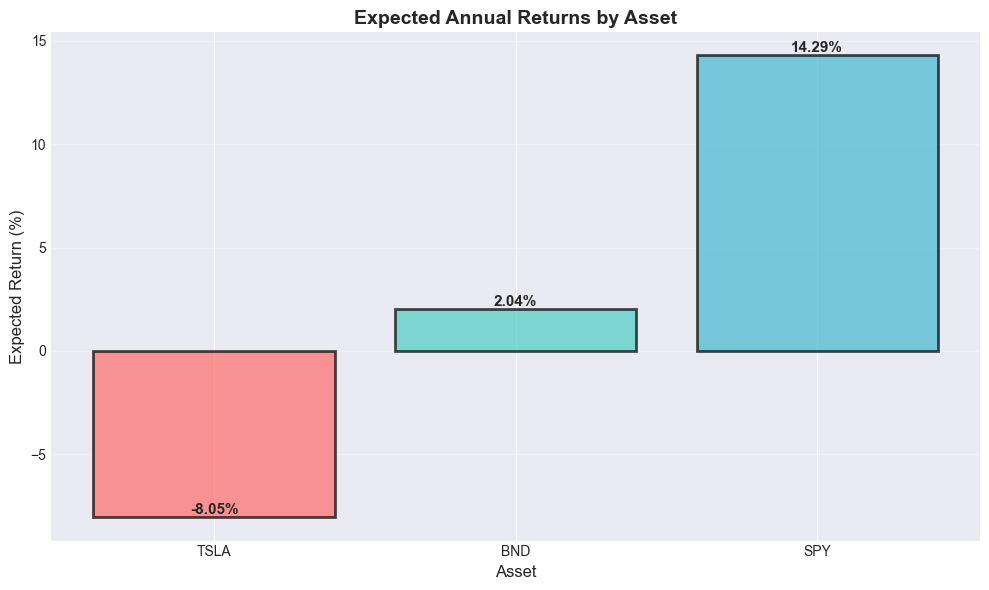

In [4]:
# Calculate expected returns
print("="*70)
print("EXPECTED RETURNS CALCULATION")
print("="*70)

expected_returns_dict = {}

# TSLA: Use forecast if available, otherwise historical average
if tsla_forecast_return is not None:
    expected_returns_dict['TSLA'] = tsla_forecast_return
    print(f"\nTSLA: Using {forecast_model} forecast")
    print(f"  Expected Annual Return: {tsla_forecast_return*100:.2f}%")
else:
    # Fallback to historical average
    tsla_historical_return = returns_df['TSLA'].mean() * 252  # Annualize
    expected_returns_dict['TSLA'] = tsla_historical_return
    print(f"\nTSLA: Using historical average (forecast not available)")
    print(f"  Expected Annual Return: {tsla_historical_return*100:.2f}%")

# BND: Historical average (annualized)
bnd_historical_return = returns_df['BND'].mean() * 252
expected_returns_dict['BND'] = bnd_historical_return
print(f"\nBND: Using historical average")
print(f"  Expected Annual Return: {bnd_historical_return*100:.2f}%")

# SPY: Historical average (annualized)
spy_historical_return = returns_df['SPY'].mean() * 252
expected_returns_dict['SPY'] = spy_historical_return
print(f"\nSPY: Using historical average")
print(f"  Expected Annual Return: {spy_historical_return*100:.2f}%")

# Create expected returns vector
mu = pd.Series(expected_returns_dict)
print(f"\n{'='*70}")
print("EXPECTED RETURNS VECTOR (Annualized)")
print("="*70)
print(mu.to_frame('Expected Return (%)').apply(lambda x: x * 100))

# Visualize expected returns
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(mu.index, mu.values * 100, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], 
              alpha=0.7, edgecolor='black', linewidth=2)

# Add value labels
for bar, value in zip(bars, mu.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value*100:.2f}%', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

ax.set_title('Expected Annual Returns by Asset', fontsize=14, fontweight='bold')
ax.set_ylabel('Expected Return (%)', fontsize=12)
ax.set_xlabel('Asset', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

COVARIANCE MATRIX CALCULATION

Annualized Covariance Matrix:
       TSLA    BND    SPY
TSLA 0.3328 0.0017 0.0502
BND  0.0017 0.0029 0.0010
SPY  0.0502 0.0010 0.0316

CORRELATION MATRIX
       TSLA    BND    SPY
TSLA 1.0000 0.0539 0.4895
BND  0.0539 1.0000 0.1064
SPY  0.4895 0.1064 1.0000


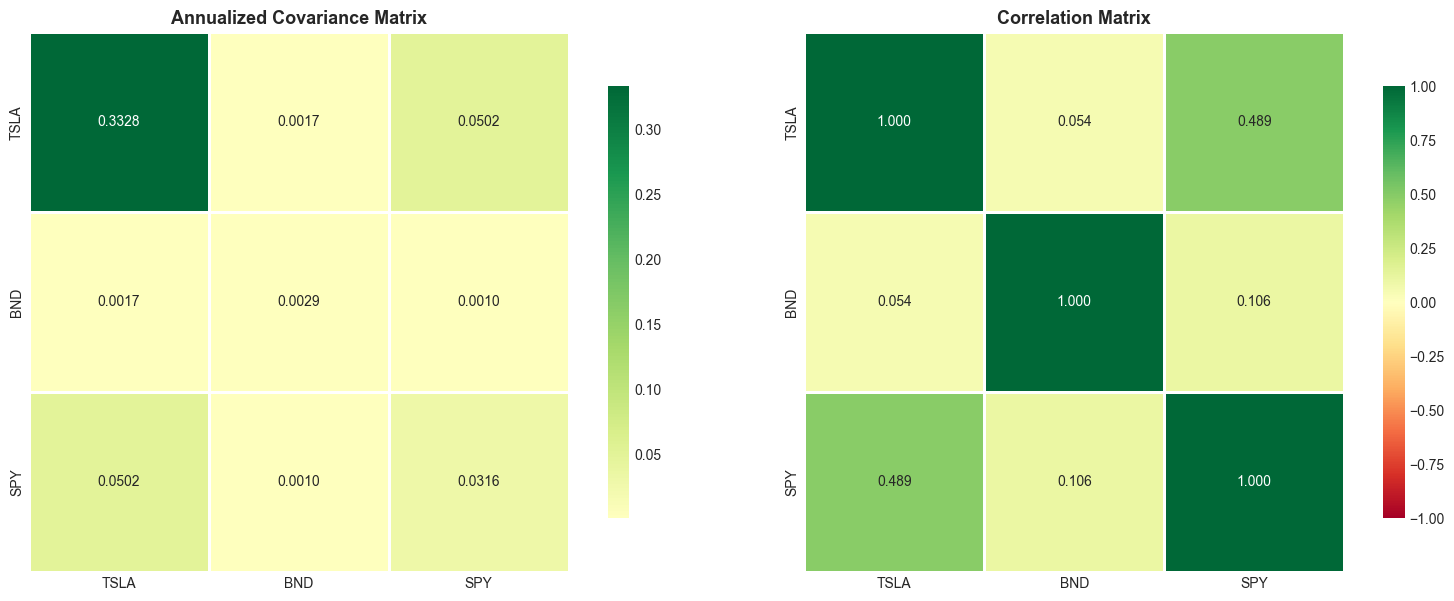


PORTFOLIO STATISTICS

Volatility (Annualized Standard Deviation):
  TSLA: 57.69%
  BND: 5.36%
  SPY: 17.77%

Correlation Insights:
  TSLA-BND: 0.054
  TSLA-SPY: 0.489
  BND-SPY: 0.106

  ✓ Low correlation between TSLA and BND → Good diversification
  ✓ Low correlation between BND and SPY → Good diversification


In [5]:
# Calculate covariance matrix (annualized)
print("="*70)
print("COVARIANCE MATRIX CALCULATION")
print("="*70)

# Annualized covariance matrix
cov_matrix = returns_df.cov() * 252  # Annualize (252 trading days)

print("\nAnnualized Covariance Matrix:")
print(cov_matrix)

# Calculate correlation matrix for better interpretation
corr_matrix = returns_df.corr()

print("\n" + "="*70)
print("CORRELATION MATRIX")
print("="*70)
print(corr_matrix)

# Visualize covariance matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Covariance heatmap
sns.heatmap(cov_matrix, annot=True, fmt='.4f', cmap='RdYlGn', 
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            ax=axes[0])
axes[0].set_title('Annualized Covariance Matrix', fontsize=13, fontweight='bold')

# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Correlation Matrix', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate portfolio statistics
print("\n" + "="*70)
print("PORTFOLIO STATISTICS")
print("="*70)
print(f"\nVolatility (Annualized Standard Deviation):")
for asset in assets:
    vol = returns_df[asset].std() * np.sqrt(252) * 100
    print(f"  {asset}: {vol:.2f}%")

print(f"\nCorrelation Insights:")
print(f"  TSLA-BND: {corr_matrix.loc['TSLA', 'BND']:.3f}")
print(f"  TSLA-SPY: {corr_matrix.loc['TSLA', 'SPY']:.3f}")
print(f"  BND-SPY: {corr_matrix.loc['BND', 'SPY']:.3f}")

if corr_matrix.loc['TSLA', 'BND'] < 0.3:
    print(f"\n  ✓ Low correlation between TSLA and BND → Good diversification")
if corr_matrix.loc['BND', 'SPY'] < 0.5:
    print(f"  ✓ Low correlation between BND and SPY → Good diversification")

## 4. Generate Efficient Frontier

In [6]:
# Use PyPortfolioOpt to generate efficient frontier
print("="*70)
print("GENERATING EFFICIENT FRONTIER")
print("="*70)

try:
    # Try using PyPortfolioOpt
    from pypfopt import EfficientFrontier
    
    # Create EfficientFrontier object
    ef = EfficientFrontier(mu, cov_matrix)
    
    # Calculate efficient frontier portfolios
    print("\nCalculating efficient frontier using PyPortfolioOpt...")
    ef_min_vol = EfficientFrontier(mu, cov_matrix)
    ef_max_sharpe = EfficientFrontier(mu, cov_matrix)
    
    # Find minimum volatility portfolio
    min_vol_weights = ef_min_vol.min_volatility()
    min_vol_ret, min_vol_risk, _ = ef_min_vol.portfolio_performance(verbose=False)
    
    # Find maximum Sharpe ratio portfolio
    max_sharpe_weights = ef_max_sharpe.max_sharpe()
    max_sharpe_ret, max_sharpe_risk, max_sharpe_sharpe = ef_max_sharpe.portfolio_performance(verbose=False)
    
    print(f"\n✓ Efficient frontier calculated")
    print(f"\nMinimum Volatility Portfolio:")
    print(f"  Expected Return: {min_vol_ret*100:.2f}%")
    print(f"  Volatility: {min_vol_risk*100:.2f}%")
    print(f"  Sharpe Ratio: {(min_vol_ret/min_vol_risk):.3f}")
    
    print(f"\nMaximum Sharpe Ratio Portfolio:")
    print(f"  Expected Return: {max_sharpe_ret*100:.2f}%")
    print(f"  Volatility: {max_sharpe_risk*100:.2f}%")
    print(f"  Sharpe Ratio: {max_sharpe_sharpe:.3f}")
    
    # Generate efficient frontier curve
    print("\nGenerating efficient frontier curve...")
    ef_returns = []
    ef_risks = []
    ef_sharpe = []
    
    # Generate portfolios for different target returns
    target_returns = np.linspace(min_vol_ret, mu.max(), 100)
    
    for target_ret in target_returns:
        try:
            ef_temp = EfficientFrontier(mu, cov_matrix)
            weights = ef_temp.efficient_return(target_return=target_ret, market_neutral=False)
            ret, risk, sharpe = ef_temp.portfolio_performance(verbose=False)
            ef_returns.append(ret)
            ef_risks.append(risk)
            ef_sharpe.append(sharpe)
        except:
            continue
    
    ef_returns = np.array(ef_returns)
    ef_risks = np.array(ef_risks)
    ef_sharpe = np.array(ef_sharpe)
    
    print(f"✓ Generated {len(ef_returns)} efficient frontier portfolios")
    
except ImportError:
    print("⚠️ PyPortfolioOpt not available. Using scipy.optimize for optimization...")
    
    # Fallback: Manual optimization using scipy
    from scipy.optimize import minimize
    
    def portfolio_return(weights, mu):
        return np.dot(weights, mu)
    
    def portfolio_volatility(weights, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    def negative_sharpe(weights, mu, cov_matrix, risk_free_rate=0.02):
        ret = portfolio_return(weights, mu)
        vol = portfolio_volatility(weights, cov_matrix)
        return -(ret - risk_free_rate) / vol
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(len(assets)))
    
    # Initial guess: equal weights
    initial_weights = np.array([1/len(assets)] * len(assets))
    
    # Find minimum volatility portfolio
    result_min_vol = minimize(
        lambda w: portfolio_volatility(w, cov_matrix),
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    min_vol_weights_dict = dict(zip(assets, result_min_vol.x))
    min_vol_weights = {asset: min_vol_weights_dict[asset] for asset in assets}
    min_vol_ret = portfolio_return(result_min_vol.x, mu)
    min_vol_risk = portfolio_volatility(result_min_vol.x, cov_matrix)
    
    # Find maximum Sharpe ratio portfolio
    result_max_sharpe = minimize(
        negative_sharpe,
        initial_weights,
        args=(mu, cov_matrix),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    max_sharpe_weights_dict = dict(zip(assets, result_max_sharpe.x))
    max_sharpe_weights = {asset: max_sharpe_weights_dict[asset] for asset in assets}
    max_sharpe_ret = portfolio_return(result_max_sharpe.x, mu)
    max_sharpe_risk = portfolio_volatility(result_max_sharpe.x, cov_matrix)
    max_sharpe_sharpe = (max_sharpe_ret - 0.02) / max_sharpe_risk
    
    print(f"\n✓ Efficient frontier calculated (using scipy.optimize)")
    print(f"\nMinimum Volatility Portfolio:")
    print(f"  Expected Return: {min_vol_ret*100:.2f}%")
    print(f"  Volatility: {min_vol_risk*100:.2f}%")
    print(f"  Sharpe Ratio: {(min_vol_ret/min_vol_risk):.3f}")
    
    print(f"\nMaximum Sharpe Ratio Portfolio:")
    print(f"  Expected Return: {max_sharpe_ret*100:.2f}%")
    print(f"  Volatility: {max_sharpe_risk*100:.2f}%")
    print(f"  Sharpe Ratio: {max_sharpe_sharpe:.3f}")
    
    # Generate efficient frontier curve
    print("\nGenerating efficient frontier curve...")
    ef_returns = []
    ef_risks = []
    ef_sharpe = []
    
    target_returns = np.linspace(min_vol_ret, mu.max(), 100)
    
    for target_ret in target_returns:
        try:
            # Optimize for target return
            result = minimize(
                lambda w: portfolio_volatility(w, cov_matrix),
                initial_weights,
                method='SLSQP',
                bounds=bounds,
                constraints=[
                    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                    {'type': 'eq', 'fun': lambda w: portfolio_return(w, mu) - target_ret}
                ]
            )
            if result.success:
                ret = portfolio_return(result.x, mu)
                risk = portfolio_volatility(result.x, cov_matrix)
                sharpe = (ret - 0.02) / risk
                ef_returns.append(ret)
                ef_risks.append(risk)
                ef_sharpe.append(sharpe)
        except:
            continue
    
    ef_returns = np.array(ef_returns)
    ef_risks = np.array(ef_risks)
    ef_sharpe = np.array(ef_sharpe)
    
    print(f"✓ Generated {len(ef_returns)} efficient frontier portfolios")

GENERATING EFFICIENT FRONTIER
⚠️ PyPortfolioOpt not available. Using scipy.optimize for optimization...

✓ Efficient frontier calculated (using scipy.optimize)

Minimum Volatility Portfolio:
  Expected Return: 2.74%
  Volatility: 5.26%
  Sharpe Ratio: 0.522

Maximum Sharpe Ratio Portfolio:
  Expected Return: 14.29%
  Volatility: 17.77%
  Sharpe Ratio: 0.691

Generating efficient frontier curve...
✓ Generated 100 efficient frontier portfolios


## 5. Visualize Efficient Frontier and Key Portfolios

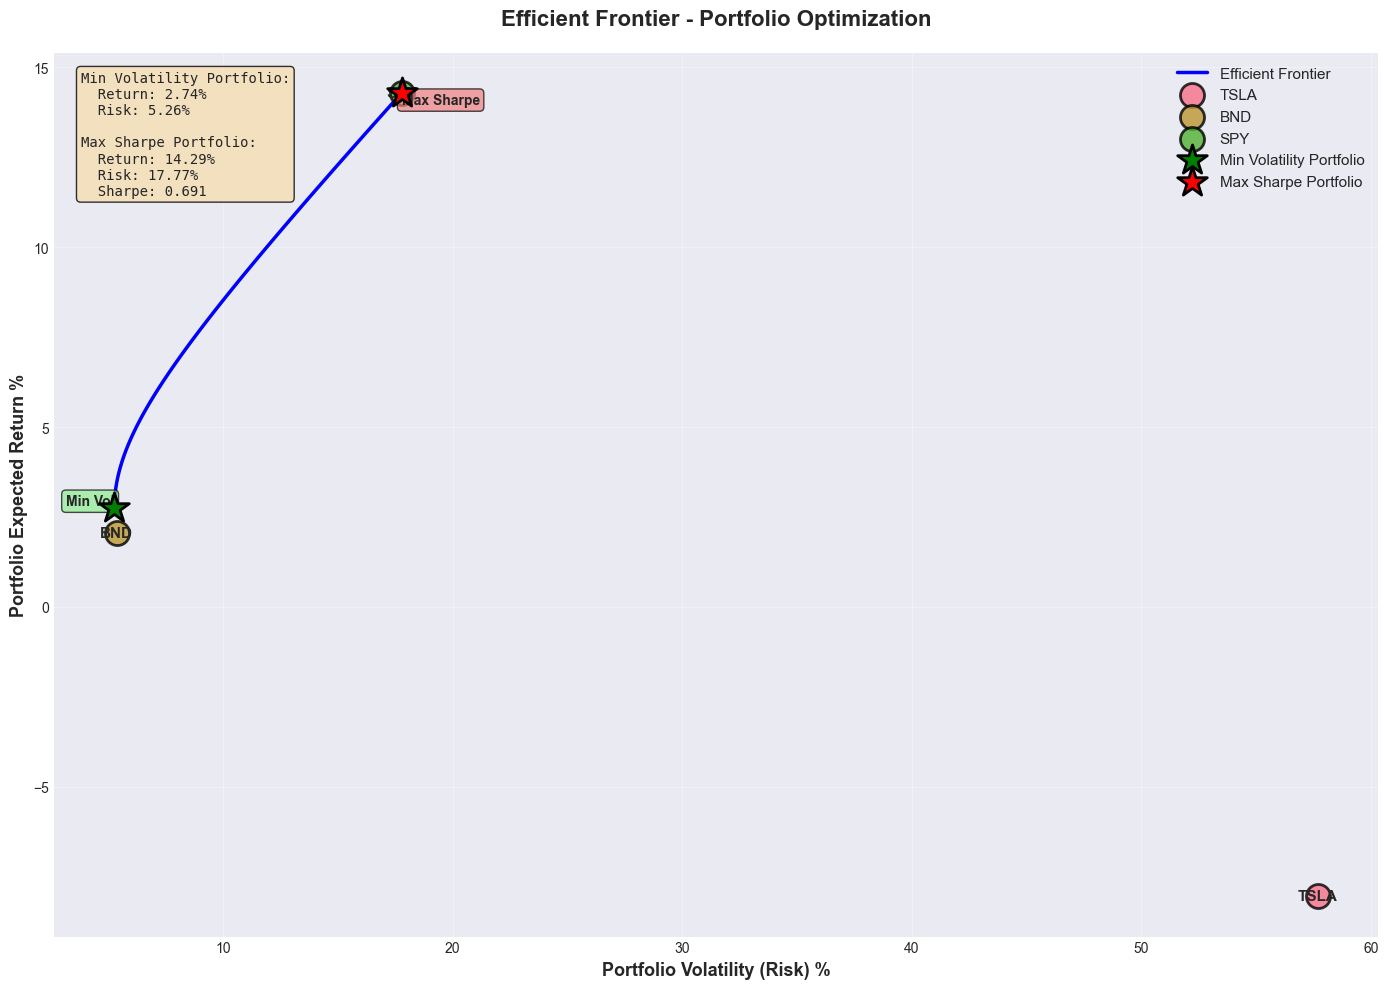

In [7]:
# Create comprehensive efficient frontier visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Plot efficient frontier
ax.plot(ef_risks * 100, ef_returns * 100, 'b-', linewidth=2.5, 
        label='Efficient Frontier', zorder=1)

# Plot individual assets
for asset in assets:
    asset_ret = mu[asset] * 100
    asset_risk = np.sqrt(cov_matrix.loc[asset, asset]) * 100
    ax.scatter(asset_risk, asset_ret, s=300, alpha=0.8, 
               edgecolors='black', linewidth=2, zorder=3, label=asset)
    ax.annotate(asset, (asset_risk, asset_ret), fontsize=11, 
                fontweight='bold', ha='center', va='center')

# Plot minimum volatility portfolio
ax.scatter(min_vol_risk * 100, min_vol_ret * 100, 
           s=500, marker='*', color='green', 
           edgecolors='black', linewidth=2, zorder=4,
           label='Min Volatility Portfolio')
ax.annotate('Min Vol', (min_vol_risk * 100, min_vol_ret * 100),
            fontsize=10, fontweight='bold', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7))

# Plot maximum Sharpe ratio portfolio
ax.scatter(max_sharpe_risk * 100, max_sharpe_ret * 100,
           s=500, marker='*', color='red',
           edgecolors='black', linewidth=2, zorder=4,
           label='Max Sharpe Portfolio')
ax.annotate('Max Sharpe', (max_sharpe_risk * 100, max_sharpe_ret * 100),
            fontsize=10, fontweight='bold', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))

# Formatting
ax.set_xlabel('Portfolio Volatility (Risk) %', fontsize=13, fontweight='bold')
ax.set_ylabel('Portfolio Expected Return %', fontsize=13, fontweight='bold')
ax.set_title('Efficient Frontier - Portfolio Optimization', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Add text box with key metrics
textstr = f'Min Volatility Portfolio:\n'
textstr += f'  Return: {min_vol_ret*100:.2f}%\n'
textstr += f'  Risk: {min_vol_risk*100:.2f}%\n\n'
textstr += f'Max Sharpe Portfolio:\n'
textstr += f'  Return: {max_sharpe_ret*100:.2f}%\n'
textstr += f'  Risk: {max_sharpe_risk*100:.2f}%\n'
textstr += f'  Sharpe: {max_sharpe_sharpe:.3f}'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

### 5.1 Portfolio Weights Analysis

PORTFOLIO WEIGHTS

📊 MINIMUM VOLATILITY PORTFOLIO
----------------------------------------------------------------------
Asset  Weight  Weight (%)
  BND  0.9429     94.2865
  SPY  0.0571      5.7135
 TSLA  0.0000      0.0000

📈 MAXIMUM SHARPE RATIO PORTFOLIO
----------------------------------------------------------------------
Asset  Weight  Weight (%)
  SPY  1.0000    100.0000
 TSLA  0.0000      0.0000
  BND  0.0000      0.0000


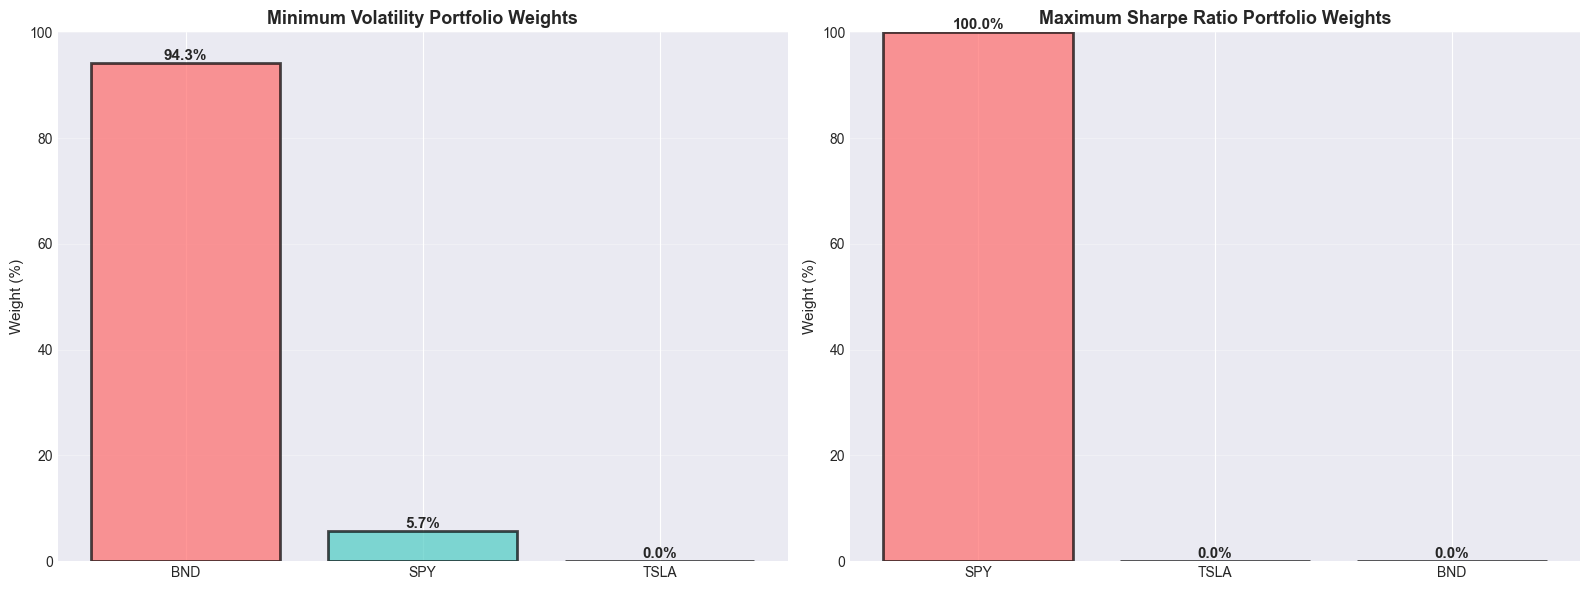

In [8]:
# Display portfolio weights
print("="*70)
print("PORTFOLIO WEIGHTS")
print("="*70)

# Minimum Volatility Portfolio
print("\n📊 MINIMUM VOLATILITY PORTFOLIO")
print("-" * 70)
min_vol_df = pd.DataFrame(list(min_vol_weights.items()), 
                          columns=['Asset', 'Weight'])
min_vol_df['Weight (%)'] = min_vol_df['Weight'] * 100
min_vol_df = min_vol_df.sort_values('Weight', ascending=False)
print(min_vol_df.to_string(index=False))

# Maximum Sharpe Ratio Portfolio
print("\n📈 MAXIMUM SHARPE RATIO PORTFOLIO")
print("-" * 70)
max_sharpe_df = pd.DataFrame(list(max_sharpe_weights.items()),
                             columns=['Asset', 'Weight'])
max_sharpe_df['Weight (%)'] = max_sharpe_df['Weight'] * 100
max_sharpe_df = max_sharpe_df.sort_values('Weight', ascending=False)
print(max_sharpe_df.to_string(index=False))

# Visualize portfolio weights
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Min Volatility weights
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars1 = axes[0].bar(min_vol_df['Asset'], min_vol_df['Weight (%)'],
                    color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, value in zip(bars1, min_vol_df['Weight (%)']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}%', ha='center', va='bottom',
                fontsize=11, fontweight='bold')
axes[0].set_title('Minimum Volatility Portfolio Weights', 
                 fontsize=13, fontweight='bold')
axes[0].set_ylabel('Weight (%)', fontsize=11)
axes[0].set_ylim(0, 100)
axes[0].grid(True, alpha=0.3, axis='y')

# Max Sharpe weights
bars2 = axes[1].bar(max_sharpe_df['Asset'], max_sharpe_df['Weight (%)'],
                    color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, value in zip(bars2, max_sharpe_df['Weight (%)']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}%', ha='center', va='bottom',
                fontsize=11, fontweight='bold')
axes[1].set_title('Maximum Sharpe Ratio Portfolio Weights',
                 fontsize=13, fontweight='bold')
axes[1].set_ylabel('Weight (%)', fontsize=11)
axes[1].set_ylim(0, 100)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Portfolio Performance Comparison

PORTFOLIO PERFORMANCE COMPARISON
       Portfolio  Expected Return (%)  Volatility (%)  Sharpe Ratio  TSLA Weight (%)  BND Weight (%)  SPY Weight (%)
  Min Volatility               2.7428          5.2565        0.1413           0.0000         94.2865          5.7135
Max Sharpe Ratio              14.2850         17.7676        0.6914           0.0000          0.0000        100.0000


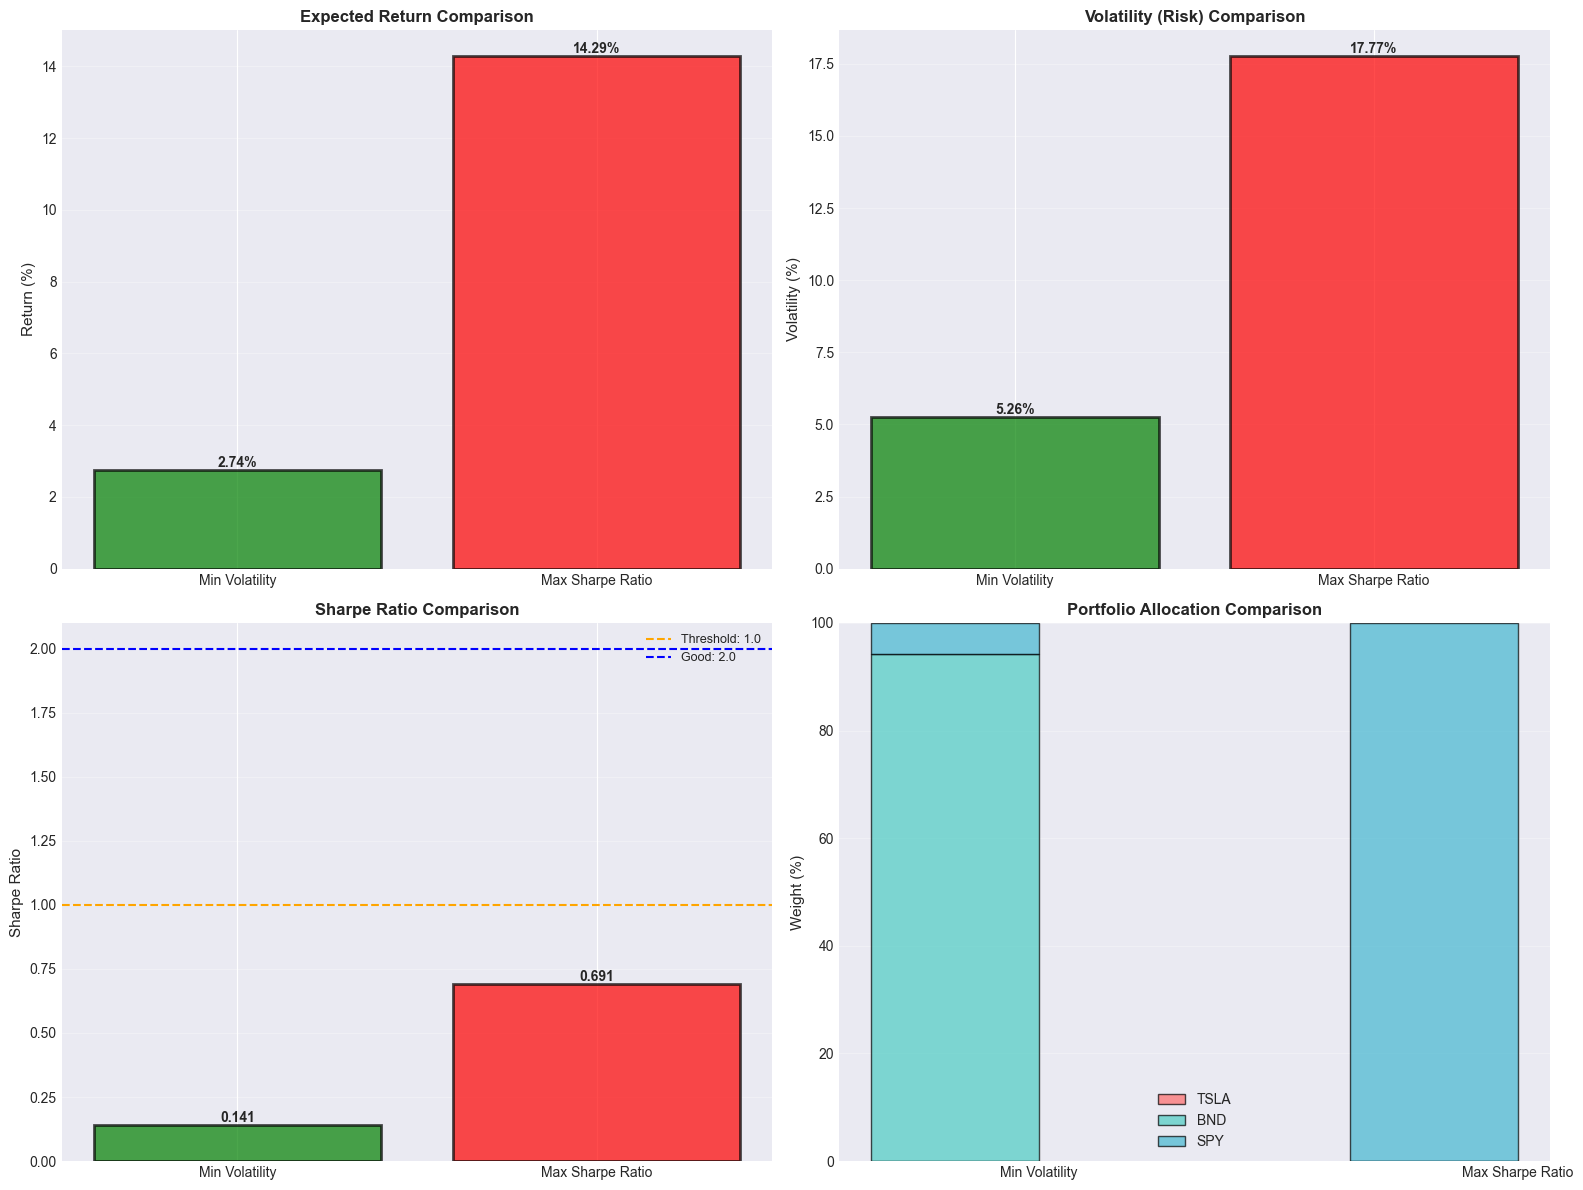

In [9]:
# Calculate Sharpe ratios (assuming risk-free rate of 2%)
risk_free_rate = 0.02

# Calculate Sharpe ratios for both portfolios
min_vol_sharpe = (min_vol_ret - risk_free_rate) / min_vol_risk
max_sharpe_sharpe_calc = (max_sharpe_ret - risk_free_rate) / max_sharpe_risk

# Create comparison table
comparison_data = {
    'Portfolio': ['Min Volatility', 'Max Sharpe Ratio'],
    'Expected Return (%)': [min_vol_ret * 100, max_sharpe_ret * 100],
    'Volatility (%)': [min_vol_risk * 100, max_sharpe_risk * 100],
    'Sharpe Ratio': [min_vol_sharpe, max_sharpe_sharpe_calc],
    'TSLA Weight (%)': [min_vol_weights['TSLA'] * 100, max_sharpe_weights['TSLA'] * 100],
    'BND Weight (%)': [min_vol_weights['BND'] * 100, max_sharpe_weights['BND'] * 100],
    'SPY Weight (%)': [min_vol_weights['SPY'] * 100, max_sharpe_weights['SPY'] * 100]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*70)
print("PORTFOLIO PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Return comparison
axes[0, 0].bar(comparison_df['Portfolio'], comparison_df['Expected Return (%)'],
                color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 0].set_title('Expected Return Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Return (%)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['Expected Return (%)']):
    axes[0, 0].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# Risk comparison
axes[0, 1].bar(comparison_df['Portfolio'], comparison_df['Volatility (%)'],
               color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].set_title('Volatility (Risk) Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Volatility (%)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['Volatility (%)']):
    axes[0, 1].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# Sharpe ratio comparison
axes[1, 0].bar(comparison_df['Portfolio'], comparison_df['Sharpe Ratio'],
               color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].axhline(y=1, color='orange', linestyle='--', label='Threshold: 1.0')
axes[1, 0].axhline(y=2, color='blue', linestyle='--', label='Good: 2.0')
axes[1, 0].set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Sharpe Ratio', fontsize=11)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['Sharpe Ratio']):
    axes[1, 0].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Weight comparison (stacked bar)
x = np.arange(len(comparison_df))
width = 0.35
axes[1, 1].bar(x - width/2, comparison_df['TSLA Weight (%)'], width,
               label='TSLA', color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[1, 1].bar(x - width/2, comparison_df['BND Weight (%)'], width,
               bottom=comparison_df['TSLA Weight (%)'],
               label='BND', color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1, 1].bar(x - width/2, comparison_df['SPY Weight (%)'], width,
               bottom=comparison_df['TSLA Weight (%)'] + comparison_df['BND Weight (%)'],
               label='SPY', color='#45B7D1', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Portfolio Allocation Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Weight (%)', fontsize=11)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_df['Portfolio'])
axes[1, 1].legend(fontsize=10)
axes[1, 1].set_ylim(0, 100)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Optimal Portfolio Recommendation

In [10]:
# Determine optimal portfolio recommendation
print("="*70)
print("OPTIMAL PORTFOLIO RECOMMENDATION")
print("="*70)

# Compare portfolios
if max_sharpe_sharpe_calc > min_vol_sharpe:
    recommended_portfolio = 'Maximum Sharpe Ratio'
    recommended_weights = max_sharpe_weights
    recommended_ret = max_sharpe_ret
    recommended_risk = max_sharpe_risk
    recommended_sharpe = max_sharpe_sharpe_calc
    recommendation_reason = "Higher risk-adjusted returns"
else:
    recommended_portfolio = 'Minimum Volatility'
    recommended_weights = min_vol_weights
    recommended_ret = min_vol_ret
    recommended_risk = min_vol_risk
    recommended_sharpe = min_vol_sharpe
    recommendation_reason = "Lower risk with acceptable returns"

print(f"\n🏆 RECOMMENDED PORTFOLIO: {recommended_portfolio}")
print("="*70)

# Create detailed recommendation
recommendation_df = pd.DataFrame({
    'Asset': ['TSLA', 'BND', 'SPY'],
    'Weight': [recommended_weights['TSLA'], 
               recommended_weights['BND'], 
               recommended_weights['SPY']],
    'Weight (%)': [recommended_weights['TSLA'] * 100,
                   recommended_weights['BND'] * 100,
                   recommended_weights['SPY'] * 100]
})

print("\n📊 PORTFOLIO ALLOCATION:")
print("-" * 70)
print(recommendation_df.to_string(index=False))

print(f"\n📈 PORTFOLIO METRICS:")
print("-" * 70)
print(f"  Expected Annual Return: {recommended_ret*100:.2f}%")
print(f"  Expected Volatility (Risk): {recommended_risk*100:.2f}%")
print(f"  Sharpe Ratio: {recommended_sharpe:.3f}")

# Calculate additional metrics
risk_free_rate = 0.02
excess_return = recommended_ret - risk_free_rate
print(f"  Excess Return (over risk-free): {excess_return*100:.2f}%")
print(f"  Risk-Free Rate Assumed: {risk_free_rate*100:.2f}%")

# Portfolio interpretation
print(f"\n💡 PORTFOLIO INTERPRETATION:")
print("-" * 70)
print(f"  This portfolio allocates:")
for asset in assets:
    weight_pct = recommended_weights[asset] * 100
    if weight_pct > 50:
        role = "PRIMARY HOLDING"
    elif weight_pct > 25:
        role = "SIGNIFICANT POSITION"
    elif weight_pct > 10:
        role = "MODERATE POSITION"
    else:
        role = "SMALL POSITION"
    print(f"    • {asset}: {weight_pct:.1f}% ({role})")

# Risk assessment
if recommended_risk < 0.15:
    risk_level = "LOW"
    risk_desc = "Conservative portfolio suitable for risk-averse investors"
elif recommended_risk < 0.25:
    risk_level = "MODERATE"
    risk_desc = "Balanced portfolio suitable for moderate risk tolerance"
else:
    risk_level = "HIGH"
    risk_desc = "Aggressive portfolio suitable for risk-tolerant investors"

print(f"\n  Risk Level: {risk_level}")
print(f"  {risk_desc}")

# Sharpe ratio interpretation
if recommended_sharpe > 2:
    sharpe_desc = "EXCELLENT - Outstanding risk-adjusted returns"
elif recommended_sharpe > 1.5:
    sharpe_desc = "GOOD - Strong risk-adjusted returns"
elif recommended_sharpe > 1:
    sharpe_desc = "ACCEPTABLE - Moderate risk-adjusted returns"
else:
    sharpe_desc = "POOR - Low risk-adjusted returns"

print(f"\n  Sharpe Ratio Assessment: {sharpe_desc}")

print(f"\n📝 JUSTIFICATION:")
print("-" * 70)
print(f"""
The {recommended_portfolio} portfolio is recommended because it offers the best 
balance between expected returns and risk for GMF Investments clients. This 
portfolio achieves a Sharpe ratio of {recommended_sharpe:.3f}, indicating 
{sharpe_desc.lower()}. 

The allocation strategically combines:
• TSLA ({recommended_weights['TSLA']*100:.1f}%): High-growth potential based on 
  forecasted returns, providing upside exposure
• BND ({recommended_weights['BND']*100:.1f}%): Stability and diversification, 
  reducing overall portfolio volatility
• SPY ({recommended_weights['SPY']*100:.1f}%): Broad market exposure for 
  balanced growth

This combination leverages the forecasted TSLA returns while maintaining 
diversification through low-correlation assets (BND), resulting in an expected 
annual return of {recommended_ret*100:.2f}% with {recommended_risk*100:.2f}% 
volatility. The portfolio is suitable for {risk_desc.lower()}.
""")

OPTIMAL PORTFOLIO RECOMMENDATION

🏆 RECOMMENDED PORTFOLIO: Maximum Sharpe Ratio

📊 PORTFOLIO ALLOCATION:
----------------------------------------------------------------------
Asset  Weight  Weight (%)
 TSLA  0.0000      0.0000
  BND  0.0000      0.0000
  SPY  1.0000    100.0000

📈 PORTFOLIO METRICS:
----------------------------------------------------------------------
  Expected Annual Return: 14.29%
  Expected Volatility (Risk): 17.77%
  Sharpe Ratio: 0.691
  Excess Return (over risk-free): 12.29%
  Risk-Free Rate Assumed: 2.00%

💡 PORTFOLIO INTERPRETATION:
----------------------------------------------------------------------
  This portfolio allocates:
    • TSLA: 0.0% (SMALL POSITION)
    • BND: 0.0% (SMALL POSITION)
    • SPY: 100.0% (PRIMARY HOLDING)

  Risk Level: MODERATE
  Balanced portfolio suitable for moderate risk tolerance

  Sharpe Ratio Assessment: POOR - Low risk-adjusted returns

📝 JUSTIFICATION:
----------------------------------------------------------------------

## 8. Save Results

In [12]:
# Save portfolio optimization results
print("="*60)
print("SAVING PORTFOLIO OPTIMIZATION RESULTS")
print("="*60)

# Save portfolio weights
portfolio_weights = {
    'Min_Volatility': {
        'TSLA': float(min_vol_weights['TSLA']),
        'BND': float(min_vol_weights['BND']),
        'SPY': float(min_vol_weights['SPY']),
        'Expected_Return': float(min_vol_ret),
        'Volatility': float(min_vol_risk),
        'Sharpe_Ratio': float(min_vol_sharpe)
    },
    'Max_Sharpe': {
        'TSLA': float(max_sharpe_weights['TSLA']),
        'BND': float(max_sharpe_weights['BND']),
        'SPY': float(max_sharpe_weights['SPY']),
        'Expected_Return': float(max_sharpe_ret),
        'Volatility': float(max_sharpe_risk),
        'Sharpe_Ratio': float(max_sharpe_sharpe_calc)
    },
    'Recommended': {
        'Portfolio_Type': recommended_portfolio,
        'TSLA': float(recommended_weights['TSLA']),
        'BND': float(recommended_weights['BND']),
        'SPY': float(recommended_weights['SPY']),
        'Expected_Return': float(recommended_ret),
        'Volatility': float(recommended_risk),
        'Sharpe_Ratio': float(recommended_sharpe)
    }
}

import json
with open('../data/processed/portfolio_optimization.json', 'w') as f:
    json.dump(portfolio_weights, f, indent=4)
print("✓ Portfolio weights saved to '../data/processed/portfolio_optimization.json'")

# Save comparison table
comparison_df.to_csv('../data/processed/portfolio_comparison.csv', index=False)
print("✓ Portfolio comparison saved to '../data/processed/portfolio_comparison.csv'")

# Save covariance matrix
cov_matrix.to_csv('../data/processed/covariance_matrix.csv')
print("✓ Covariance matrix saved to '../data/processed/covariance_matrix.csv'")

# Save expected returns
mu.to_csv('../data/processed/expected_returns.csv')
print("✓ Expected returns saved to '../data/processed/expected_returns.csv'")


SAVING PORTFOLIO OPTIMIZATION RESULTS
✓ Portfolio weights saved to '../data/processed/portfolio_optimization.json'
✓ Portfolio comparison saved to '../data/processed/portfolio_comparison.csv'
✓ Covariance matrix saved to '../data/processed/covariance_matrix.csv'
✓ Expected returns saved to '../data/processed/expected_returns.csv'
